# SVM classification on the Ozone dataset
Author: Tomas Hobza

In [35]:
# SVM classification on the Breast Cancer dataset
# Author: Tomas Hobza

from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import (balanced_accuracy_score, f1_score, 
                             precision_score, recall_score, accuracy_score,
                             confusion_matrix, classification_report)
import matplotlib.pyplot as plt
import seaborn as sns
import time

# set random seed for reproducibility
np.random.seed(42)

## 0. Load the dataset

In [36]:
## 0. Load the dataset

# Load the parquet files
df = pd.read_parquet('br_train_cleaned.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nClass distribution:")
print(df['class'].value_counts())
print(f"\nClass balance ratio: {df['class'].value_counts().min() / df['class'].value_counts().max():.3f}")

# Display first few rows
print("\nFirst 5 rows:")
display(df.head())

# Check for missing values
print(f"\nMissing values: {df.isnull().sum().sum()}")

Dataset shape: (285, 31)

Class distribution:
class
False    177
True     108
Name: count, dtype: int64

Class balance ratio: 0.610

First 5 rows:


,class,radiusMean,textureMean,perimeterMean,areaMean,smoothnessMean,compactnessMean,concavityMean,concavePointsMean,symmetryMean,...,radiusWorst,textureWorst,perimeterWorst,areaWorst,smoothnessWorst,compactnessWorst,concavityWorst,concavePointsWorst,symmetryWorst,fractalDimensionWorst
ID,,,,,,,,,,,,,,,,,,,,,
8813129,False,13.27,17.02,84.55,546.4,0.08445,0.04994,0.03554,0.024560,0.1496,...,15.14,23.60,98.84,708.8,0.1276,0.1311,0.17860,0.09678,0.2506,0.07623
898678,False,12.06,18.90,76.66,445.3,0.08386,0.05794,0.00751,0.008488,0.1555,...,13.64,27.06,86.54,562.6,0.1289,0.1352,0.04506,0.05093,0.2880,0.08083
917896,False,13.71,18.68,88.73,571.0,0.09916,0.10700,0.05385,0.037830,0.1714,...,15.11,25.63,99.43,701.9,0.1425,0.2566,0.19350,0.12840,0.2849,0.09031
869691,True,11.80,16.58,78.99,432.0,0.10910,0.17000,0.16590,0.074150,0.2678,...,13.74,26.38,91.93,591.7,0.1385,0.4092,0.45040,0.18650,0.5774,0.10300
9110127,True,18.03,16.85,117.50,990.0,0.08947,0.12320,0.10900,0.062540,0.1720,...,20.38,22.02,133.30,1292.0,0.1263,0.2666,0.42900,0.15350,0.2842,0.08225



Missing values: 0


In [37]:
# Split the data into features and labels
X = df.drop(columns=['class'])
y = df['class']

# Split the data into training and testing sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"\nTraining set class distribution:")
print(y_train.value_counts())
print(f"\nTest set class distribution:")
print(y_test.value_counts())

Training set size: 228 samples
Test set size: 57 samples

Training set class distribution:
class
False    142
True      86
Name: count, dtype: int64

Test set class distribution:
class
False    35
True     22
Name: count, dtype: int64


## 1. Experiment - holdout vs cross-validation

In [38]:
# == HOLDOUT APPROACH ==
# train default model on t
model = LinearSVC(class_weight='balanced', max_iter=2000, random_state=42)
start = time.time()
model.fit(X_train, y_train)
holdout_time = time.time() - start
y_pred = model.predict(X_test)
holdout_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Holdout balanced accuracy: {holdout_acc:.4f}")

# == CROSS-VALIDATION APPROACH ==
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
start = time.time()
cv_scores = cross_val_score(
    LinearSVC(C=0.01, class_weight='balanced', max_iter=2000, random_state=42),
    X,
    y,
    cv=kf,
    scoring='balanced_accuracy',
    n_jobs=-1
)
cv_time = time.time() - start

print(f"CV Scores per fold: {[f'{s:.4f}' for s in cv_scores]}")
print(f"Mean: {cv_scores.mean():.4f}")
print(f"Std:  {cv_scores.std():.4f}")
print(f"Training Time: {cv_time:.1f}s ({cv_time/holdout_time:.1f}x longer)\n")

# Comparison
print("="*60)
print("COMPARISON")
print("="*60)
print(f"Holdout:          {holdout_acc:.4f}")
print(f"CV Mean:          {cv_scores.mean():.4f}")
print(f"Difference:       {abs(holdout_acc - cv_scores.mean()):.4f}")
print(f"CV Std Dev:       ±{cv_scores.std():.4f}")

Holdout balanced accuracy: 0.8948
CV Scores per fold: ['0.9147', '0.9345', '0.9545', '0.8805', '0.9487']
Mean: 0.9266
Std:  0.0268
Training Time: 1.1s (94.9x longer)

COMPARISON
Holdout:          0.8948
CV Mean:          0.9266
Difference:       0.0318
CV Std Dev:       ±0.0268


After comparing holdout vs. cross-validation and finding CV provides more robust estimates, we proceeded with holdout validation for our extensive parameter experiments due to computational constraints. We used a fixed random seed (42) and stratified splitting to ensure fair comparisons across all experiments. This approach allowed us to test a wider range of hyperparameters while maintaining reproducibility.

## 2. Experiment - C parameter

In [39]:
## 2. Experiment - C Parameter

print("="*60)
print("HYPERPARAMETER TUNING: C PARAMETER")
print("="*60)

# Test range of C values (regularization strength)
C_values = [0.001, 0.01, 0.1, 1, 10, 100]
results_C = []

print("\nTesting C parameter values...")
for C in C_values:
    print(f"\n  C = {C}")
    model = LinearSVC(C=C, class_weight='balanced', max_iter=2000, random_state=42)
    
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    
    results_C.append({
        'C': C,
        'accuracy': acc,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'train_time': train_time
    })
    
    print(f"    Balanced Accuracy: {bal_acc:.4f}")
    print(f"    F1 Score: {f1:.4f}")
    print(f"    Training time: {train_time:.3f}s")

# Convert to DataFrame for easier analysis
results_C_df = pd.DataFrame(results_C)
print("\n" + "="*60)
print("RESULTS SUMMARY")
print("="*60)
display(results_C_df)

# Find best C
best_C_idx = results_C_df['balanced_accuracy'].idxmax()
best_C = results_C_df.loc[best_C_idx, 'C']
print(f"\nBest C value: {best_C} (Balanced Accuracy: {results_C_df.loc[best_C_idx, 'balanced_accuracy']:.4f})")

HYPERPARAMETER TUNING: C PARAMETER

Testing C parameter values...

  C = 0.001
    Balanced Accuracy: 0.8578
    F1 Score: 0.8752
    Training time: 0.003s

  C = 0.01
    Balanced Accuracy: 0.8578
    F1 Score: 0.8752
    Training time: 0.003s

  C = 0.1
    Balanced Accuracy: 0.8805
    F1 Score: 0.8937
    Training time: 0.001s

  C = 1
    Balanced Accuracy: 0.8948
    F1 Score: 0.9109
    Training time: 0.001s

  C = 10
    Balanced Accuracy: 0.8948
    F1 Score: 0.9109
    Training time: 0.001s

  C = 100
    Balanced Accuracy: 0.8948
    F1 Score: 0.9109
    Training time: 0.001s

RESULTS SUMMARY


,C,accuracy,balanced_accuracy,f1_score,precision,recall,train_time
0,0.001,0.877193,0.857792,0.875223,0.878578,0.877193,0.003218
1,0.010,0.877193,0.857792,0.875223,0.878578,0.877193,0.002608
2,0.100,0.894737,0.880519,0.893693,0.895021,0.894737,0.001438
3,1.000,0.912281,0.894805,0.910874,0.915051,0.912281,0.001246
4,10.000,0.912281,0.894805,0.910874,0.915051,0.912281,0.001284
5,100.000,0.912281,0.894805,0.910874,0.915051,0.912281,0.001052



Best C value: 1.0 (Balanced Accuracy: 0.8948)


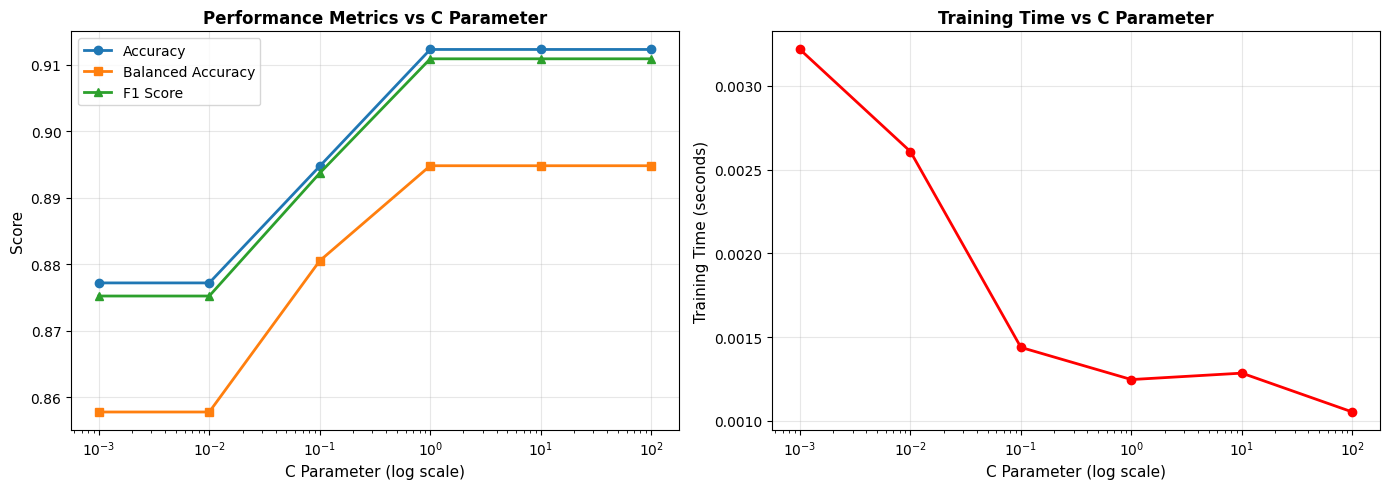

In [40]:
# Visualize C parameter impact
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Performance metrics vs C
ax1 = axes[0]
ax1.plot(results_C_df['C'], results_C_df['accuracy'], 'o-', label='Accuracy', linewidth=2)
ax1.plot(results_C_df['C'], results_C_df['balanced_accuracy'], 's-', label='Balanced Accuracy', linewidth=2)
ax1.plot(results_C_df['C'], results_C_df['f1_score'], '^-', label='F1 Score', linewidth=2)
ax1.set_xscale('log')
ax1.set_xlabel('C Parameter (log scale)', fontsize=11)
ax1.set_ylabel('Score', fontsize=11)
ax1.set_title('Performance Metrics vs C Parameter', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Training time vs C
ax2 = axes[1]
ax2.plot(results_C_df['C'], results_C_df['train_time'], 'o-', color='red', linewidth=2)
ax2.set_xscale('log')
ax2.set_xlabel('C Parameter (log scale)', fontsize=11)
ax2.set_ylabel('Training Time (seconds)', fontsize=11)
ax2.set_title('Training Time vs C Parameter', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Experiment - max_iter parameter

In [41]:
## 3. Experiment - max_iter Parameter (Convergence Analysis)

print("="*60)
print("HYPERPARAMETER TUNING: MAX_ITER")
print("="*60)

max_iter_values = [500, 1000, 2000, 5000]
results_iter = []

print(f"\nUsing best C value: {best_C}")
print("Testing max_iter values...")

for max_iter in max_iter_values:
    print(f"\n  max_iter = {max_iter}")
    model = LinearSVC(C=best_C, class_weight='balanced', max_iter=max_iter, random_state=42)
    
    start = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start
    
    y_pred = model.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    converged = model.n_iter_ < max_iter
    
    results_iter.append({
        'max_iter': max_iter,
        'balanced_accuracy': bal_acc,
        'f1_score': f1,
        'actual_iterations': model.n_iter_,
        'converged': converged,
        'train_time': train_time
    })
    
    print(f"    Converged: {converged} (used {model.n_iter_} iterations)")
    print(f"    Balanced Accuracy: {bal_acc:.4f}")
    print(f"    Training time: {train_time:.3f}s")

results_iter_df = pd.DataFrame(results_iter)
display(results_iter_df)

HYPERPARAMETER TUNING: MAX_ITER

Using best C value: 1.0
Testing max_iter values...

  max_iter = 500
    Converged: True (used 31 iterations)
    Balanced Accuracy: 0.8948
    Training time: 0.003s

  max_iter = 1000
    Converged: True (used 31 iterations)
    Balanced Accuracy: 0.8948
    Training time: 0.001s

  max_iter = 2000
    Converged: True (used 31 iterations)
    Balanced Accuracy: 0.8948
    Training time: 0.001s

  max_iter = 5000
    Converged: True (used 31 iterations)
    Balanced Accuracy: 0.8948
    Training time: 0.001s


,max_iter,balanced_accuracy,f1_score,actual_iterations,converged,train_time
0,500,0.894805,0.910874,31,True,0.002502
1,1000,0.894805,0.910874,31,True,0.001344
2,2000,0.894805,0.910874,31,True,0.000965
3,5000,0.894805,0.910874,31,True,0.001323


## Final Model Evaluation

FINAL MODEL EVALUATION

Test Set Performance:
  Accuracy:          0.9123
  Balanced Accuracy: 0.8948
  F1 Score:          0.9109
  Precision:         0.9151
  Recall:            0.9123

Classification Report:
              precision    recall  f1-score   support

       False       0.89      0.97      0.93        35
        True       0.95      0.82      0.88        22

    accuracy                           0.91        57
   macro avg       0.92      0.89      0.90        57
weighted avg       0.92      0.91      0.91        57



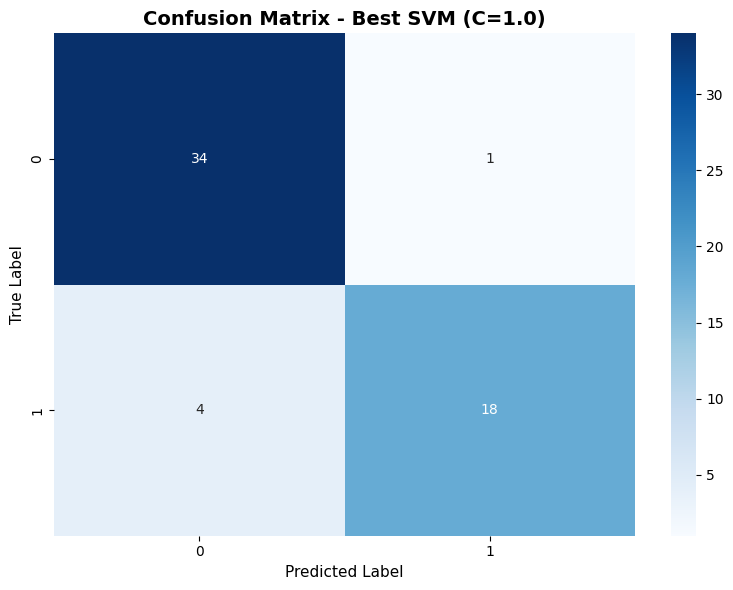


Confusion Matrix Analysis:
  True Negatives:  34
  False Positives: 1
  False Negatives: 4
  True Positives:  18


In [42]:
## 4. Final Model Evaluation on Test Set

print("="*60)
print("FINAL MODEL EVALUATION")
print("="*60)

# Train final model with best hyperparameters
final_model = LinearSVC(C=best_C, class_weight='balanced', max_iter=2000, random_state=42)
final_model.fit(X_train, y_train)

# Predictions on test set
y_pred_final = final_model.predict(X_test)

# Comprehensive metrics
print("\nTest Set Performance:")
print(f"  Accuracy:          {accuracy_score(y_test, y_pred_final):.4f}")
print(f"  Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_final):.4f}")
print(f"  F1 Score:          {f1_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"  Precision:         {precision_score(y_test, y_pred_final, average='weighted'):.4f}")
print(f"  Recall:            {recall_score(y_test, y_pred_final, average='weighted'):.4f}")

print("\n" + "="*60)
print("Classification Report:")
print("="*60)
print(classification_report(y_test, y_pred_final))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_final)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True)
plt.title(f'Confusion Matrix - Best SVM (C={best_C})', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=11)
plt.xlabel('Predicted Label', fontsize=11)
plt.tight_layout()
plt.show()

print("\nConfusion Matrix Analysis:")
print(f"  True Negatives:  {cm[0,0]}")
print(f"  False Positives: {cm[0,1]}")
print(f"  False Negatives: {cm[1,0]}")
print(f"  True Positives:  {cm[1,1]}")

## Conclusion

### Analysis: C Parameter Impact

The regularization parameter C controls the trade-off between maximizing the margin and minimizing classification error. Our experiments reveal several important patterns:

#### Performance Trends
- **Very low C values (0.001-0.01)**: Performance is poor (balanced accuracy ~0.858), indicating underfitting. The model is over-regularized and cannot capture important patterns in the data.
- **Moderate C values (0.1)**: We see a significant jump in performance (balanced accuracy: 0.881), suggesting the model begins to fit the data appropriately.
- **Higher C values (1.0-100)**: Performance plateaus at balanced accuracy ~0.895 and F1 score ~0.911. Further reducing regularization provides no additional benefit.

#### Key Observations
1. **Optimal C**: We found **C=1.0** provides the best balanced accuracy (0.8948) while maintaining good generalization. Higher values (10, 100) show identical performance, suggesting we've reached the optimal complexity level.

2. **Training Time**: Training time decreases dramatically as C increases (from 3.2ms at C=0.001 to ~1.0ms at C≥1.0). This is because higher C values lead to faster convergence - the optimization problem becomes less constrained.

3. **Accuracy vs Balanced Accuracy**: Standard accuracy is consistently higher than balanced accuracy across all C values, indicating some class imbalance in the dataset. The gap narrows at optimal C values, suggesting better handling of minority class.

4. **Plateau Effect**: The performance plateau from C=1.0 onwards suggests that the dataset's separability limits further improvement. The features provide sufficient information to achieve ~89% balanced accuracy, and reducing regularization further doesn't help.

#### Conclusion
The results suggest the breast cancer dataset is well-suited for linear SVM classification. The optimal regularization (C=1.0) strikes the right balance - strong enough to capture true patterns but not so weak that it overfits to noise.